# Variational classifier
<a id="0"></a>
1. [Variational classifier for purity function](#1)
   1. [Model](#2)
   2. [Cost function](#3)
   3. [Optimization](#4)
   4. [Test accuracy](#5)
2. [Iris classification](#6)
   1. [Model](#7)
   2. [Cost function](#8)
   3. [Optimization](#9)
   4. [Test accuracy](#10)

<a id="1"></a>
## Variational classifier for purity function

Variational classifier is a model intends to solve is that of supervised pattern recognition. This type of problem has numerous applications, including image recognition, fraud detection, medical diagnosis, and many other fields.
A variational classifier is a type of quantum machine learning model that combines classical machine learning techniques with quantum computing. It uses a parameterized quantum circuit, also known as a variational circuit, to process input data and perform classification tasks. The parameters of the quantum circuit are optimized during training to minimize a cost function, similar to how weights are optimized in classical neural networks.

<a id="2"></a>
## Model

Variational classifiers usually define a “layer” or “block”, which is an elementary circuit architecture that gets repeated to build the full variational circuit.

Loaded the data

In [1]:
from pennylane import numpy as np
data = np.loadtxt("./data/parity_4_qubit_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


Instead of writing out each gate ([qml.Rot](https://docs.pennylane.ai/en/stable/code/api/pennylane.Rot.html), [qml.CNOT]()) application individually, we used the built-in function `qml.broadcast`, which allows us to specify the operation once and apply it to all specified qubits in a single command.
Function [qml.broadcast](https://docs.pennylane.ai/en/stable/code/api/pennylane.broadcast.html) applies a unitary multiple times to a specific pattern of wires. This function enables scalable implementation by facilitating uniform operations across a large qubit register without the need for manual repetirion, which would be cumbersome and error-prone in large-scale circuit.

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

dev = qml.device("default.qubit")
def layer(layer_weights, wires):
    qml.broadcast(qml.Rot,wires=wires,pattern='single',parameters=layer_weights)
    qml.broadcast(qml.CNOT, wires=wires, pattern='ring')

Let's check our layer circuit.

(<Figure size 800x500 with 1 Axes>, <Axes: >)

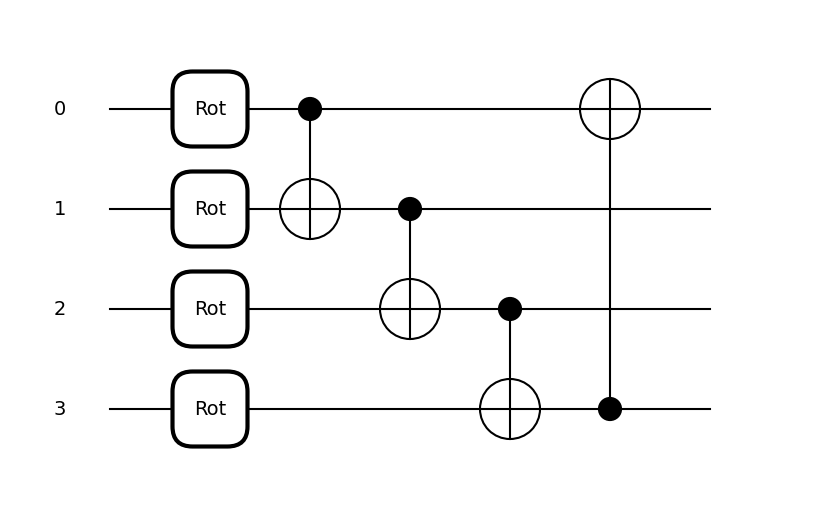

In [3]:
layer_weights = 0.01 * np.random.randn(4,3, requires_grad=True)
# layer_weights = [[-0.01659417, 0.02280296,0.01775596]], [[-0.01659417, 0.02280296,0.01775596]], [[-0.01659417, 0.02280296,0.01775596]],[[-0.01659417, 0.02280296,0.01775596]]
wires = [i for i in range(4)]
qml.draw_mpl(layer)(layer_weights,wires)

Now we need to encode our classic data into circuit. We use [qml.BasisState](https://docs.pennylane.ai/en/stable/code/api/pennylane.BasisState.html). We parametrize wires depending on the length of X.

In [4]:
def state_preparation(x,wires):
    qml.BasisState(x, wires=wires)

Now, we define the variational quantum circuit, where `state_preparation` initializes the quantum state based on input data, `weights` parameterize the quantum gates or operations in each layer, and the expectation value calculation provides a measure of the circuit's performance or output.

In [6]:
dev = qml.device("default.qubit")
@qml.qnode(dev)
def circuit(weights, x):
    wires = [i for i in range(len(X[0]))]

    state_preparation(x,wires)

    for layer_weights in weights:
        layer(layer_weights, wires)

    return qml.expval(qml.PauliZ(0))

Incorporating a bias parameter ensures our variational quantum classifier is more versatile and capable of handling a wider range of data distributions, leading to better performance and more accurate predictions.

In [7]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

<a id="3"></a>
## Cost function



In [8]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]

    return square_loss(Y, predictions)
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

<a id="4"></a>
## Optimization

The small initial weight values are chosen to ensure that the training process starts smoothly and avoids numerical issues that could arise from very large or very small initial weights. This practice is based on empirical findings that suggest models train more effectively when starting with small random weights.

In [9]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


In [10]:
from pennylane.optimize import NesterovMomentumOptimizer
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

In [11]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step_and_cost(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 2.3147651 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9664866 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.9208589 | Accuracy: 0.5000000
Iter:    4 | Cost: 2.6276126 | Accuracy: 0.5000000
Iter:    5 | Cost: 0.9323119 | Accuracy: 0.6000000
Iter:    6 | Cost: 1.1903549 | Accuracy: 0.5000000
Iter:    7 | Cost: 2.0508989 | Accuracy: 0.4000000
Iter:    8 | Cost: 1.1275531 | Accuracy: 0.6000000
Iter:    9 | Cost: 1.1659803 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.1349618 | Accuracy: 0.6000000
Iter:   11 | Cost: 0.9994063 | Accuracy: 0.6000000
Iter:   12 | Cost: 1.0812559 | Accuracy: 0.6000000
Iter:   13 | Cost: 1.2863155 | Accuracy: 0.6000000
Iter:   14 | Cost: 2.2658259 | Accuracy: 0.4000000
Iter:   15 | Cost: 1.1323724 | Accuracy: 0.6000000
Iter:   16 | Cost: 1.3439737 | Accuracy: 0.8000000
Iter:   17 | Cost: 2.0076168 | Accuracy: 0.6000000
Iter:   18 | Cost: 1.2685760 | Accuracy: 0.5000000
Iter:   19 | Cost: 1.6762475 | Accuracy: 0.5000000
Iter:   20 | Cost: 1.1868237 | 

In [12]:
data = np.loadtxt("./data/parity_4_qubit_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


In [22]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
dev = qml.device("default.qubit")
def layer(layer_weights, wires):
    qml.broadcast(qml.Rot,wires=wires,pattern='single',parameters=layer_weights)
    qml.broadcast(qml.CNOT, wires=wires, pattern='ring')

def state_preparation(x,wires):
    qml.BasisState(x, wires=wires)

@qml.qnode(dev)
def circuit(weights, x):
    wires = [i for i in range(len(X[0]))]

    state_preparation(x,wires)

    for layer_weights in weights:
        layer(layer_weights, wires)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

data = np.loadtxt("./data/parity_4_qubit_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1
Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0
Iter:    1 | Cost: 2.3147651 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9664866 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.9208589 | Accuracy: 0.5000000
Iter:    4 | Cost: 2.6276126 | Accuracy: 0.5000000
Iter:    5 | Cost: 0.9323119 | Accuracy: 0.6000000
Iter:    6 | Cost: 1.1903549 | Accuracy: 0.5000000
Iter:    7 | Cost: 2.0508989 | Accuracy: 0.4000000
Iter:    8 | Cost: 1.1275531 | Accuracy: 0.6000000
Iter:    9 | Cost: 1.1659803 | Acc